In [ ]:
import simpy
import random
import numpy as np
import scipy as sp 
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp, ttest_ind
from statsmodels.sandbox.stats.multicomp import multipletests

In [ ]:
sim_time = 50000                       # The time for which the simulation will run

## M/M/1 Shortes jobs first

In [15]:
class Service_station(object):
    def __init__(self, env, S_n):
        '''    
        Initialization enviroment, with servers
            S_n is the number of servers that will be created
        '''
        self.env = env
        self.servers = simpy.PriorityResource(env, S_n)

    def serve(self, customer, prio):
        '''
         Processes customer in prio time. 
             customer: referes to the customer that gets processed
             prio: the priority of the customer which will be correlated to the serving time.
        '''
        serving_time = prio 
        yield self.env.timeout(serving_time) 
#         print(f'The server processed the request of {customer} at {env.now}')

def customer(env, name, Station, data, mu): 
    '''   
    requests that object gets processed by server
        data: list of waiting times
        mu: service rate
        prio: gets drawn form a Markov distribution with mu as mean. 
        
    Saves in data:
        waiting time: time betwee arrival to getting assigned to server. 
        
    '''
    start = env.now
    prio = random.expovariate(mu)
#     print(f'{name} arrives to the Service station at {env.now}, jobsize = {prio}')
    
    with Station.servers.request(priority=prio) as req: # here we request the usage of a available server
        yield req
#         print(f'{name} is starting to be processed at {env.now}')
        
        end = env.now
        yield  env.process(Station.serve(name, prio))
#         print(f'{name} leaves the service station at {env.now}')
        
    data.append(end-start)

def setup(env, S_n, mu, Lambda, data):
    '''
    request setup with S_n servers
    creates customers at random interval drawn from Markoc distribution with mean Lambda
    
        S_n: number of servers to be created
        Lambda: arrival rate customers
        mu: process rate servers
        data: empty list that will be filled with waiting time
        
    '''
        #create service station
        workplace = Service_station(env, S_n)

        i = 0
        #create customers on the go
        while True:
            interarrival = random.expovariate(Lambda)
            yield env.timeout(interarrival)
            i += 1
            env.process(customer(env, f'Customer {i}', workplace, data, mu))



In [16]:
S_n = 1                    
mu3 = 1                    
rho3 = 0.95
Lambda3 = rho3 * S_n *mu3   
data3 = []

# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, S_n, mu3, Lambda3, data3))

# Execute!
env.run(until=sim_time)

In [ ]:
data3= np.array(data3)
E_waiting_time1 = (rho3/mu3)/(1-rho3)

print(sum(data3)/len(data3))
print(np.std(data3))

In [ ]:
ax = sns.boxplot(data = np.array(data3), orient="h",)
ax.set_xscale('log')
ax.set_title('Shortes jobs first')
ax.set_xlabel('waiting time (t)')

### statistics

In [ ]:
# Create an environment and start the setup process
S_n = 1                    # number of servers in use
mu3 = 1                     # average process time 
rho3 = 0.95
Lambda3 = rho3 * S_n *mu3    # lambda The arrival rate into the system as a whole
data3 = []

means_repeat3 = []
max_data3 = []
for i in range(100):
    datas3 = []
    env = simpy.Environment()
    env.process(setup(env, S_n, mu3, Lambda3, datas3))
    # Execute!
    env.run(until=sim_time)
    means_repeat3.append(np.array(datas3).mean())
    max_data3.append(max(datas3))

In [ ]:
print('average max waiting time:', sum(max_data3)/len(max_data3))
print('standard deviation max waiting time:', np.std(max_data3))
print('Max max waiting time:', max(max_data3))
print('standard deviation max waiting time:', np.std(max_data3))

In [ ]:
ttest_1samp(np.array(means_repeat3), 18.05)

## Deterministic model with different n 

In [ ]:
class Service_station(object):
    def __init__(self, env, S_n, mu):
        '''    
        Initialization enviroment, with servers
            S_n is the number of servers that will be created
            mu: server rate
        '''
        self.env = env
        self.servers = simpy.Resource(env, S_n)
        self.mu = mu
        
    def serve(self, customer):
        '''
        Processes cutomer with serving time equal to mu
             customer: referes to the customer that gets processed
        '''
        serving_time = self.mu  
        yield self.env.timeout(serving_time) 

def customer(env, name, Station, data):
    '''   
    requests that object gets processed by server
        data: list of waiting times
        
    Saves in data:
        waiting time: time betwee arrival to getting assigned to server. 
    '''
    
    start = env.now
    with Station.servers.request() as req: # here we request the usage of a available server
        yield req
        end = env.now
        yield env.process(Station.serve(name))
    data.append(end-start)
    
def setup(env, S_n, Lambda, mu, data):
    '''
    request setup with S_n servers
    creates customers at random interval drawn from Markoc distribution with mean Lambda
    
        S_n: number of servers to be created
        Lambda: arrival rate customers
        mu: process rate servers
        data: empty list that will be filled with waiting time
        
    '''
        #create service station
        workplace = Service_station(env, S_n, mu)
        i = 0
        #create customers on the go
        while True:
            interarrival = random.expovariate(Lambda)
            yield env.timeout(interarrival)
            i += 1
            env.process(customer(env, f'Customer {i}', workplace, data))

### n = 1

In [ ]:
#set veriables
S_n = 1                      # number of servers in use
muD1 = 1                               # The arrival rate into the system as a whole
rhoD1 = 0.95
LambdaD1 = S_n * rhoD1 * muD1             # The process time at the servers
sim_time1 = range(10,10002,100)    

means_sampsizeD1= []
for i in sim_time1:
    dataD1 = []
    # Create an environment and start the setup process
    env = simpy.Environment()
    env.process(setup(env, S_n, LambdaD1, muD1, dataD1))
    
    # Execute!
    env.run(until=i)
    means_sampsizeD1.append(sum(dataD1)/ len(dataD1))

In [ ]:
#set veriables
S_n = 1                      # number of servers in use
muD1 = 1                               # The arrival rate into the system as a whole
rhoD1 = 0.95
LambdaD1 = S_n * rhoD1 * muD1             # The process time at the servers
dataD1 = []
sim_time = 50000                       # The time for which the simulation will run

# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, S_n, LambdaD1, muD1, dataD1))

# Execute!
env.run(until=sim_time)

dataD1 = np.array(dataD1)
E_waiting_time1 = (rhoD1/muD1)/(1-rhoD1)

print(dataD1.mean())

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.hist(dataD1)
plt.title("Histogram of waiting times in a M/D/1 queue")
plt.ylabel("Frequency")
plt.xlabel("Waiting time")

### Statistics n = 1

In [ ]:
S_n = 1                      # number of servers in use
muD1 = 1                               # The arrival rate into the system as a whole
rhoD1 = 0.95
LambdaD1 = S_n * rhoD1 * muD1             # The process time at the servers
sim_time = 50000 

means_repeatD1 = []
for i in range(100):
    dataD1 = []
    env = simpy.Environment()
    env.process(setup(env, S_n, LambdaD1, muD1, dataD1))
#   Execute!
    env.run(until=sim_time)
    means_repeatD1.append(np.array(dataD1).mean())

In [ ]:
print(sum(means_repeatD1)/len(means_repeatD1))
print(np.std(means_repeatD1))
ttest_1samp(np.array(means_repeatD1), 9.5)

### n = 2

In [ ]:
#set veriables
S_n = 2                      # number of servers in use
muD2 = 1                               # The arrival rate into the system as a whole
rhoD2 = 0.95
LambdaD2 = S_n * rhoD2 * muD2             # The process time at the servers
sim_time1 = range(10,10002,100)    

means_sampsizeD2= []
for i in sim_time1:
    dataD2 = []
    # Create an environment and start the setup process
    env = simpy.Environment()
    env.process(setup(env, S_n, LambdaD2, muD2, dataD2))

    # Execute!
    env.run(until=i)
    means_sampsizeD2.append(sum(dataD2)/ len(dataD2))

In [ ]:
#set veriables
S_n = 2                      # number of servers in use
muD2 = 1                               # The arrival rate into the system as a whole
rhoD2 = 0.95
LambdaD2 = S_n * rhoD2 * muD2             # The process time at the servers
dataD2 = []
sim_time = 50000                       # The time for which the simulation will run

# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, S_n, LambdaD2, muD2, dataD2))

# Execute!
env.run(until=sim_time)

dataD2 = np.array(dataD2)
E_waiting_time2 = (rhoD2/muD2)/(1-rhoD2)

print(dataD2.mean())

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.hist(dataD2)
plt.title("Histogram of waiting times in a M/D/4 queue")
plt.ylabel("Frequency")
plt.xlabel("Waiting time")

### Statistics n = 2

In [ ]:
S_n = 2                      # number of servers in use
muD2 = 1                               # The arrival rate into the system as a whole
rhoD2 = 0.95
LambdaD2 = S_n * rhoD2 * muD2             # The process time at the servers
dataD2 = []
sim_time = 50000 

means_repeatD2 = []
for i in range(100):
    dataD2 = []
    env = simpy.Environment()
    env.process(setup(env, S_n, LambdaD2, muD2, dataD2))
#   Execute!
    env.run(until=sim_time)
    means_repeatD2.append(np.array(dataD2).mean())

In [ ]:
print(sum(means_repeatD2)/len(means_repeatD2))
print(np.std(means_repeatD2))
ttest_1samp(np.array(means_repeatD2), 4.75)

### n = 4

In [ ]:
#set veriables
S_n = 4                      # number of servers in use
mu44 = 1                               # The arrival rate into the system as a whole
rho44 = 0.95
Lambda44 = S_n * rho44 * mu44             # The process time at the servers
sim_time1 = range(2,10002,100)    

means_sampsizeD4= []
for i in sim_time1:
    dataD4 = []
    # Create an environment and start the setup process
    env = simpy.Environment()
    env.process(setup(env, S_n, Lambda44, mu44, dataD4))

    # Execute!
    env.run(until=i)
    means_sampsizeD4.append(sum(dataD4)/ len(dataD4))

In [ ]:
#set veriables
S_n = 4                      
mu44 = 1                               
rho44 = 0.95
Lambda44 = S_n * rho44 * mu44            
data44 = []
sim_time = 50000                       # The time for which the simulation will run

# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, S_n, Lambda44, mu44, data44))

# Execute!
env.run(until=sim_time)

dataD4 = np.array(dataD4)
E_waiting_time4 = (rho44/mu44)/(1-rho44)

print(dataD4.mean())

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.hist(dataD4)
plt.title("Histogram of waiting times in a M/D/4 queue")
plt.ylabel("Frequency")
plt.xlabel("Waiting time")

### Statistics n = 4

In [ ]:
S_n = 4                      # number of servers in use
muD4 = 1                               # The arrival rate into the system as a whole
rhoD4 = 0.95
LambdaD4 = S_n * rhoD4 * muD4             # The process time at the servers
dataD4 = []
sim_time = 50000 

means_repeatD4 = []
for i in range(100):
    dataD4 = []
    env = simpy.Environment()
    env.process(setup(env, S_n, LambdaD4, muD4, dataD4))
#   Execute!
    env.run(until=sim_time)
    means_repeatD4.append(np.array(dataD4).mean())

In [ ]:
print(sum(means_repeatD4)/len(means_repeatD4))
print(np.std(means_repeatD4))
ttest_1samp(np.array(means_repeatD4), 2.38)

### Plots

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(131)
plt.plot(sim_time1, means_sampsizeD1, label = "M/D/1")
plt.plot(sim_time1, np.repeat(9.5, len(sim_time1)), label = "E(W) = 9.5")
plt.axis([0,10000, 0, 50]) 
plt.ylabel("Mean waiting time")
plt.legend()
plt.subplot(132)
plt.plot(sim_time1, means_sampsizeD2, label = "M/D/2")
plt.plot(sim_time1, np.repeat(4.75, len(sim_time1)), label = "E(W) = 4.75")
plt.axis([0,10000, 0, 25]) 
plt.xlabel("Ellapsed time per run")
plt.legend()
plt.subplot(133)
plt.plot(sim_time1, means_sampsizeD4, label = "M/D/4")
plt.plot(sim_time1, np.repeat(2.38, len(sim_time1)), label = "E(W) = 2.38")
plt.axis([0,10000, 0, 12.5]) 
plt.legend()
plt.savefig("Conv_behav_MDN.png")
plt.show()


## hyperexponential Service

In [3]:
def Hyper_ex():
    '''
        returns:
            p: RV drawn from exponential distribution with mean 1 or 5 with 75% or 25% chance respectively
    '''
    x = np.random.uniform(0,1)
    if x < 0.75:
        p =  np.random.exponential(1)
        return p
    else:
        p =  np.random.exponential(5)
        return p

In [36]:
class Service_station(object):
    def __init__(self, env, S_n):
        '''    
        Initialization enviroment, with servers
            S_n is the number of servers that will be created
        '''
        self.env = env
        self.servers = simpy.Resource(env, S_n)
        
    def serve(self, customer):
        '''
        Processes cutomer with serving time drawn from Hyper exponential distribution
             customer: referes to the customer that gets processed
        '''
        serving_time = Hyper_ex()  
        yield self.env.timeout(serving_time) 

def customer(env, name, Station, data, t):
    '''   
    requests that object gets processed by server
        data: list of waiting times
        
    Saves 
        in data:
            waiting time: time betwee arrival to getting assigned to server. 
        in t:
            the time at which the costomer was processed
    '''
    start = env.now
    with Station.servers.request() as req: # here we request the usage of a available server
        yield req
        end = env.now
        yield env.process(Station.serve(name)) 
    data.append(end-start)
    t.append(end)

def setup(env, S_n, Lambda, data,t):
    '''
    request setup with S_n servers
    creates customers at random interval drawn from Markoc distribution with mean Lambda
    
        S_n: number of servers to be created
        Lambda: arrival rate customers
        mu: process rate servers
        data: empty list
        t: empty list     
    '''
    #create service station
    workplace = Service_station(env, S_n)
    i = 0
    #create customers on the go
    while True:
        interarrival = random.expovariate(Lambda)
        yield env.timeout(interarrival)
        i += 1
        env.process(customer(env, f'Customer {i}', workplace, data,t))

In [44]:
# set variables
S_n = 1                      
mu4HX = 2
rho4HX = 0.95
Lambda4HX = S_n * rho4HX * mu4HX             
data4HX = []
t = []
# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, S_n, Lambda4HX, data4HX,t))

# Execute!
env.run(until=sim_time)

Text(0.5, 0, 'time(t)')

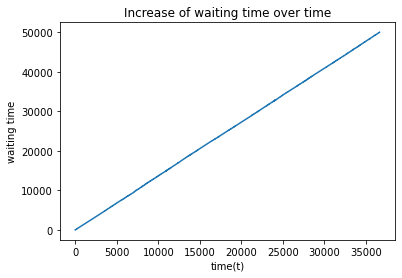

In [46]:
plt.figure()
plt.plot(data4HX, t)
plt.title("Increase of waiting time over time")
plt.ylabel("waiting time")
plt.xlabel("time(t)")

In [ ]:
data4HX = np.array(data4HX)
E_waiting_time1 = (rho4HX/mu4HX)/(1-rho4HX)

plt.figure(figsize=(9, 3))
plt.hist(data4HX)
plt.title("Histogram of waiting times in a M/H/1 queue")
plt.ylabel("Frequency")
plt.xlabel("Waiting time")

### Hyper exponential results

In [ ]:
# set variables
S_n = 1                      
mu4HX = 2
rho4HX = 0.95
Lambda4HX = S_n * rho4HX * mu4HX             
data4HX = []


means_repeat4HX = []
std_repeat4HX = []
max_repeat4HX = []

for i in range(100):
    data4HX = []
    env = simpy.Environment()
    env.process(setup(env, S_n, Lambda4HX, data4HX))
#   Execute!
    env.run(until=sim_time)
    means_repeat4HX.append(np.array(data4HX).mean()) 
    std_repeat4HX.append(np.std(data4HX))
    max_repeat4HX.append(max(data4HX))

In [ ]:
print(sum(means_repeat4HX)/len(means_repeat4HX))
print(np.std(means_repeat4HX))